In [1]:
import shioaji as sj

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="3WmNiNGCQMuPGsRMdpgML3MWYkqM1gExzPUGKKcjhufd",     # 請修改此處
    secret_key="EnKAve1Ldd8wuerMRcwKUUrB4DRmLyoxCSyoApmbzrTM"   
)

2023-03-19 19:37:48.912 | WARNING  | importlib._bootstrap:_call_with_frames_removed:228 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


抓取KBar歷史行情資料，根據需要回測的天數調整days，執行以下程式碼，會將抓到的資料存成``.csv``檔案。

In [2]:
import datetime
import pandas as pd
import os

days = 372

kbars = api.kbars(
    contract=api.Contracts.Futures.TXF.TXFR1, 
    start=(datetime.datetime.now() - datetime.timedelta(days=days)).strftime("%Y-%m-%d"), 
    end=datetime.datetime.now().strftime("%Y-%m-%d"),
)

df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df = df.set_index('ts')
df.index.name = None
df_1min = df

df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
df_1min.to_csv('TXF_1min.csv')

策略回測範例，使用5分K

In [2]:
import pandas as pd
from backtesting.lib import OHLCV_AGG


df = pd.read_csv(f"TXF_1min.csv", index_col=0)

df.index = pd.to_datetime(df.index)
df= df.between_time('08:44:00', '13:45:01')
df_resample = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df_resample.dropna(axis=0, inplace=True)
df = df_resample
print(df.head())
print(df.tail())

                        Open     High      Low    Close  Volume
2022-03-14 08:50:00  17289.0  17311.0  17271.0  17297.0    6955
2022-03-14 08:55:00  17298.0  17321.0  17293.0  17301.0    2107
2022-03-14 09:00:00  17301.0  17312.0  17284.0  17305.0    1834
2022-03-14 09:05:00  17307.0  17335.0  17300.0  17327.0    3904
2022-03-14 09:10:00  17329.0  17345.0  17323.0  17337.0    2649
                        Open     High      Low    Close  Volume
2023-03-17 13:25:00  15404.0  15413.0  15404.0  15409.0    1020
2023-03-17 13:30:00  15408.0  15418.0  15402.0  15413.0    2802
2023-03-17 13:35:00  15411.0  15417.0  15408.0  15411.0    2088
2023-03-17 13:40:00  15412.0  15418.0  15408.0  15409.0    1771
2023-03-17 13:45:00  15408.0  15411.0  15403.0  15403.0    2523


# 策略

**使用威廉指標當作技術指標**

多單策略：

進場：
* WR向上超越超買區(-30)
* 開盤15分鐘後進場

出場：
* 百分比停損 0.1%
* 跌破3根低點停利停損 
* WR跌出超買區
* 13.30平倉


空單策略：

進場：
* WR向下超越超賣區(-75)
* 開盤15分鐘後進場

出場：
* 百分比停損 0.1%
* WR向上超出超賣區
* 13.30平倉

In [34]:
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

from datetime import time

#使用威廉指標當作技術指標
class WL(Strategy): 
#     WL = 65
#     OB = -30
#     stop_pct = 5 #表示0.5%
#     OS = -75
#     L = 3
#     n1 = 7

    WL = 65
    OB = -15
    stop_pct = 5 #表示0.5%
    OS = -70
    L = 3
    n1 = 7

    def init(self):
        self.wl = self.I(ta.WILLR, self.data.High, self.data.Low, self.data.Close, self.WL)
        self.min = self.I(ta.MIN, self.data.Low, self.L)
        self.max = self.I(ta.MAX, self.data.High, self.L)
        self.sma = self.I(ta.SMA, self.data.Close, self.n1)

    def next(self):
        if (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() > time(9, 0)) and (not self.position.is_long): # 多單
            if (self.wl[-2] < self.OB) and (self.wl > self.OB): # 多單進場  
                self.buy(size=200)
        if self.position.is_long: # 多單出場
            if self.wl[-2] > self.OB and self.wl < self.OB: #WR跌出超買區
                self.position.close()
            elif self.data.Close[-1] <= self.min: #跌破3根低點停利停損
                self.position.close()
            elif self.position.pl_pct < -(self.stop_pct * 0.001): #百分比停損
                self.position.close()
                
                
        if (self.data.index[-1].time() < time(13, 30)) and (self.data.index[-1].time() > time(9, 0)) and (not self.position.is_short): # 空單
            if (self.wl[-2] < self.OS) and (self.wl > self.OS): # 空單進場
                self.sell(size=200)
        if self.position.is_short: # 空單出場
            if self.wl[-2] > self.OS and self.wl < self.OS: #WR向上超出超賣區
                self.position.close()
#             elif self.data.Close[-1] <= self.max:
#                 self.position.close()
            elif self.position.pl_pct < -(self.stop_pct * 0.001): #百分比停損
                self.position.close()
        
        if self.data.index[-1].time() >= time(13, 30) and (self.position.is_long or self.position.is_short): #平倉
                self.position.close()
    

回測部分(包含樣本內外)

In [35]:
from backtesting import Backtest

bt = Backtest(df, WL, cash=500_000, commission=0.00003, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
bt.plot(resample=False)

Start                     2022-03-14 08:50:00
End                       2023-03-17 13:45:00
Duration                    368 days 04:55:00
Exposure Time [%]                   32.862903
Equity Final [$]                   980777.884
Equity Peak [$]                    999545.486
Return [%]                          96.155577
Buy & Hold Return [%]              -10.949876
Return (Ann.) [%]                   98.298772
Volatility (Ann.) [%]               60.010605
Sharpe Ratio                         1.638023
Sortino Ratio                        7.288265
Calmar Ratio                           5.7988
Max. Drawdown [%]                   -16.95157
Avg. Drawdown [%]                   -0.937103
Max. Drawdown Duration       86 days 03:05:00
Avg. Drawdown Duration        3 days 01:46:00
# Trades                                  570
Win Rate [%]                        59.122807
Best Trade [%]                       3.116829
Worst Trade [%]                     -0.777792
Avg. Trade [%]                    

Row(id='5893', ...)

印出平倉權益曲線及績效拉回圖

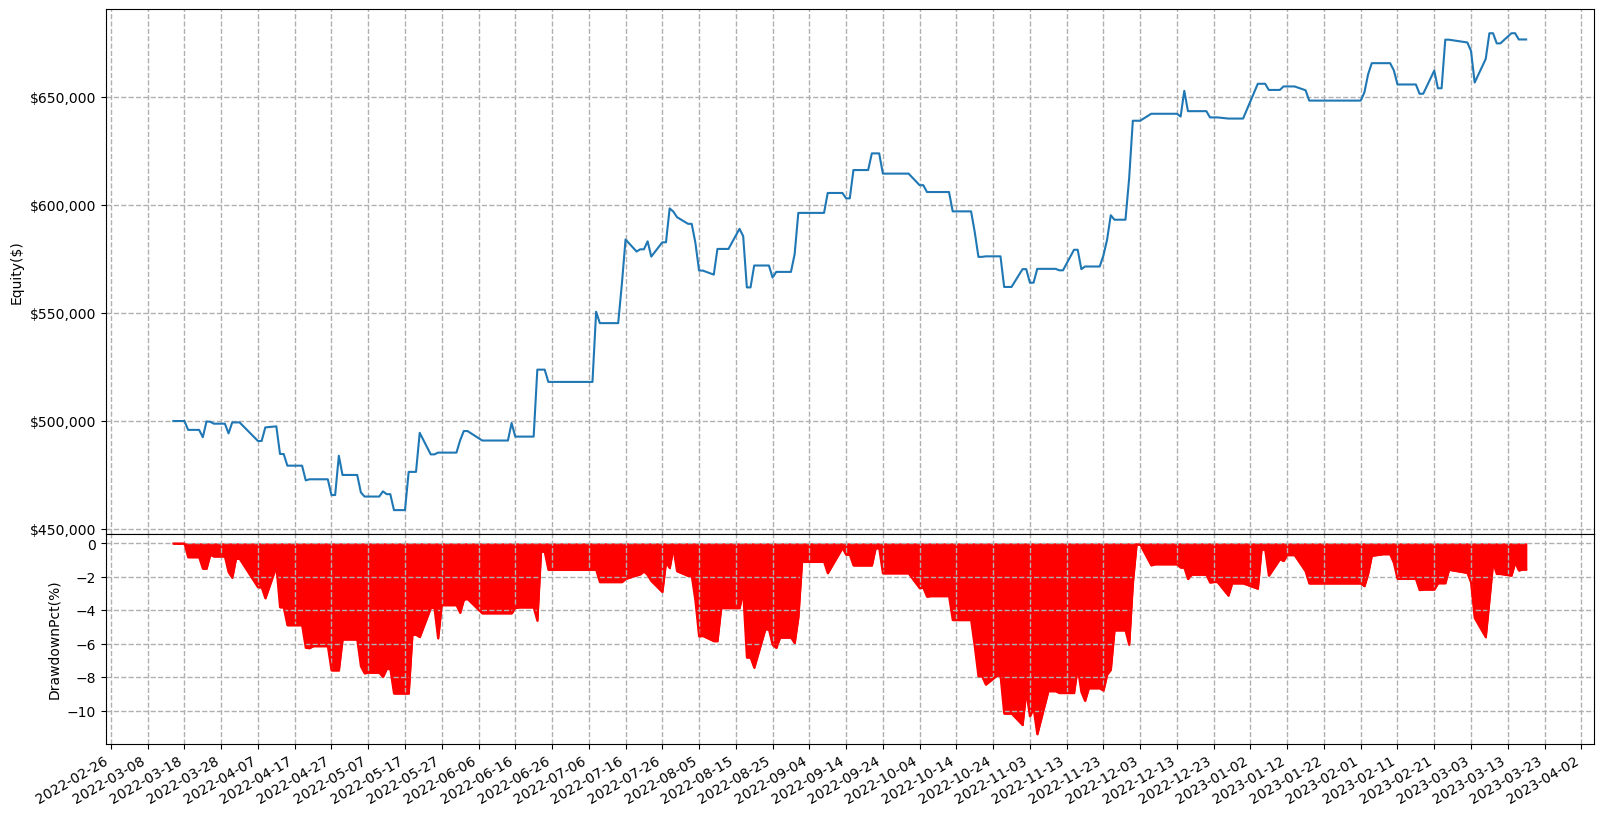

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

最佳化，只取樣本內

**對其中OB, OS, stop_pct的數值做優化**

In [22]:
# df_in_sample = df[df.index <= '2022-11-14']
# bt = Backtest(df, WL, cash=500_000, commission=0.00003, hedging=False, exclusive_orders=False, margin=0.05)
# stats = bt.optimize(OB=range(-30, -5, 5),
#                     OS=range(-70, -95, -5),
#                     stop_pct=range(1, 10, 2),
#                     maximize='Equity Final [$]',
#                     ) # 快線週期<慢線週期
# print(stats.to_string())

/Users/yun_yang/opt/anaconda3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/9 [00:00<?, ?it/s]

Start                                                   2022-03-14 08:50:00
End                                                     2023-03-17 13:45:00
Duration                                                  368 days 04:55:00
Exposure Time [%]                                                 32.862903
Equity Final [$]                                                 980777.884
Equity Peak [$]                                                  999545.486
Return [%]                                                        96.155577
Buy & Hold Return [%]                                            -10.949876
Return (Ann.) [%]                                                 98.298772
Volatility (Ann.) [%]                                             60.010605
Sharpe Ratio                                                       1.638023
Sortino Ratio                                                      7.288265
Calmar Ratio                                                         5.7988
Max. Drawdow